In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import matplotlib.image as mpimg
from matplotlib.patches import Polygon

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:

def camera_calibration(images, nx, ny):

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny,0:nx].T.reshape(-1,2)

    
    objpoints = [] 
    imgpoints = [] 


    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (ny,nx),None)


        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (ny,nx), corners, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

In [3]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=15, thresh=(0, 255)):
  
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1


    return binary_output

In [4]:
def mag_thresh(image, sobel_kernel=15, thresh=(0, 255)):
 
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1


    return binary_output



In [5]:
def dir_threshold(image, sobel_kernel=9, thresh=(0, np.pi/2)):

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

In [6]:
def col_thresh(image, thresh=(170, 255)):

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    s_channel = hls[:,:,2] 
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


In [7]:
def combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, ksize=15):
    combined = np.zeros_like(dir_binary)
    combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1

    return combined

In [8]:
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')
    
def get_histogram(image):
    return np.sum(image[image.shape[0]//2:, :], axis=0)

In [9]:

def warp(img, src_coordinates=None, dst_coordinates=None):

    img_size = (img.shape[1], img.shape[0])
    
    if src_coordinates is None:
        src_coordinates = np.float32(
            [[280,  700],  
             [595,  460],  
             [725,  460],
             [1125, 700]]) 
        
    if dst_coordinates is None:
        dst_coordinates = np.float32(
            [[250,  720],  
             [250,    0],  
             [1065,   0], 
             [1065, 720]])  

    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)

    

    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

In [10]:
def draw_lane(img, warped_img, left_points, right_points, Minv):

    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))


    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [11]:

def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    

    curvature_rads = curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)

    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    out_img = img.copy()# Shaddow Copy
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    

    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

In [12]:
def detect_lines(img, return_img=False):

    histogram = get_histogram(img)

    if return_img:
    
        out_img = np.dstack((img, img, img))*255
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    nwindows = 9
    

    window_height = np.int(img.shape[0]//nwindows)
    

    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    leftx_current = leftx_base
    rightx_current = rightx_base
  
    margin = 100


    minpix = 50
    

    left_lane_inds = []
    right_lane_inds = []


    for window in range(nwindows):

        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:

            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 


        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)


In [13]:
def detect_similar_lines(img, line_fits=None, return_img=False):
    if line_fits is None:
        return detect_lines(img, return_img)
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    if return_img:
    
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)

        
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

     
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)


In [14]:
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  
    rightx = rightx[::-1]  
    
   
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    ym_per_pix = 25/720 
    xm_per_pix = 3.7/800 


    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    

    return (left_curverad, right_curverad)


In [15]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):

    mid_imgx = img_shape[1]//2
    car_pos = (leftx[-1] + rightx[-1])/2
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [16]:
images = glob.glob('camera_cal/calibration*.jpg')

In [17]:
mtx, dist = camera_calibration(images, 6, 9)

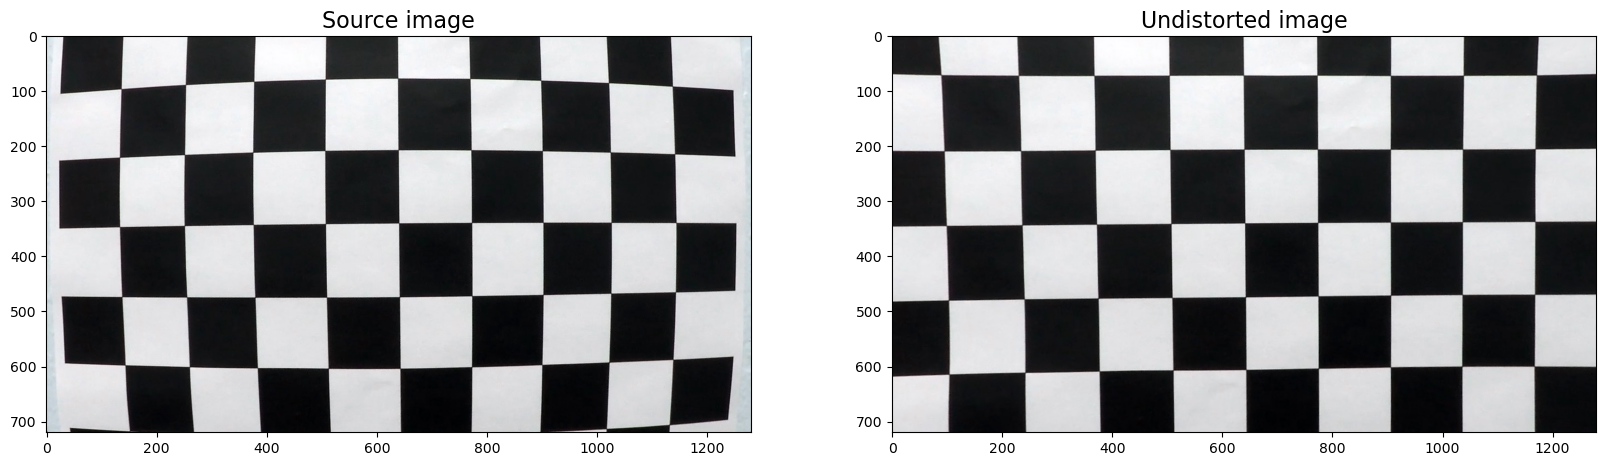

In [18]:
img = cv2.imread('camera_cal/calibration1.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None)
plt_images(img, 'Source image', undistorted_img, 'Undistorted image')

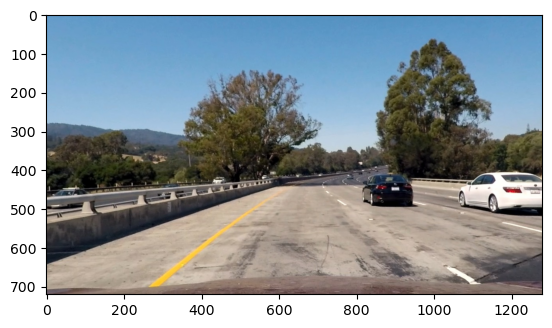

In [19]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(image)

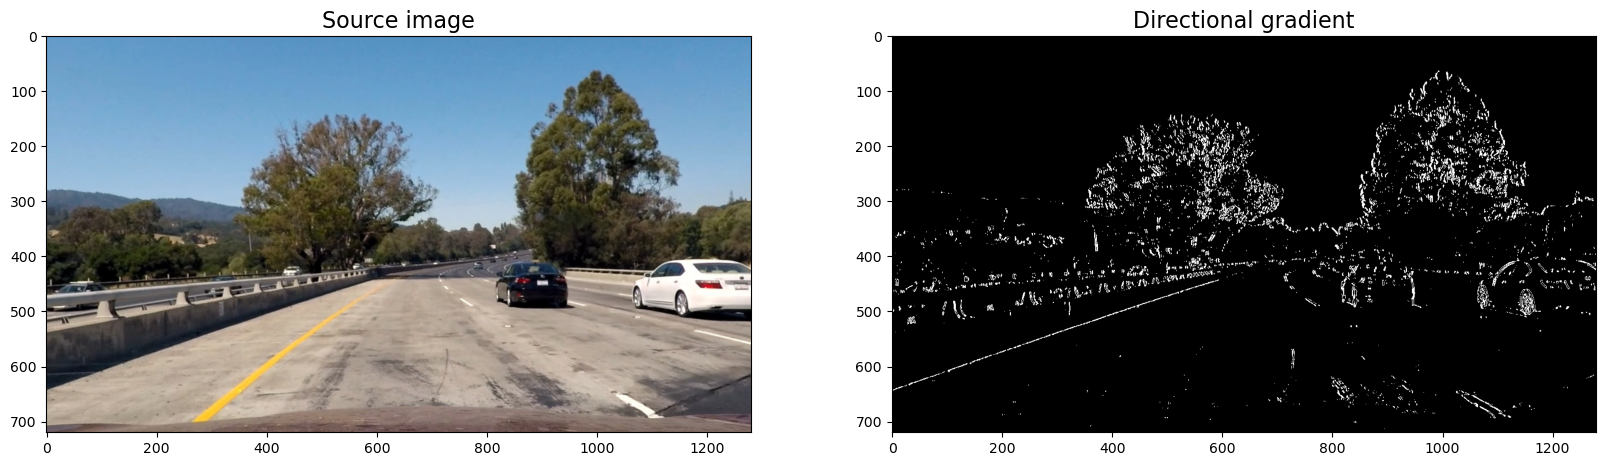

In [20]:
grad_x = abs_sobel_thresh(image, orient='x', thresh=(30, 100))
plt_images(image, 'Source image', grad_x, 'Directional gradient')

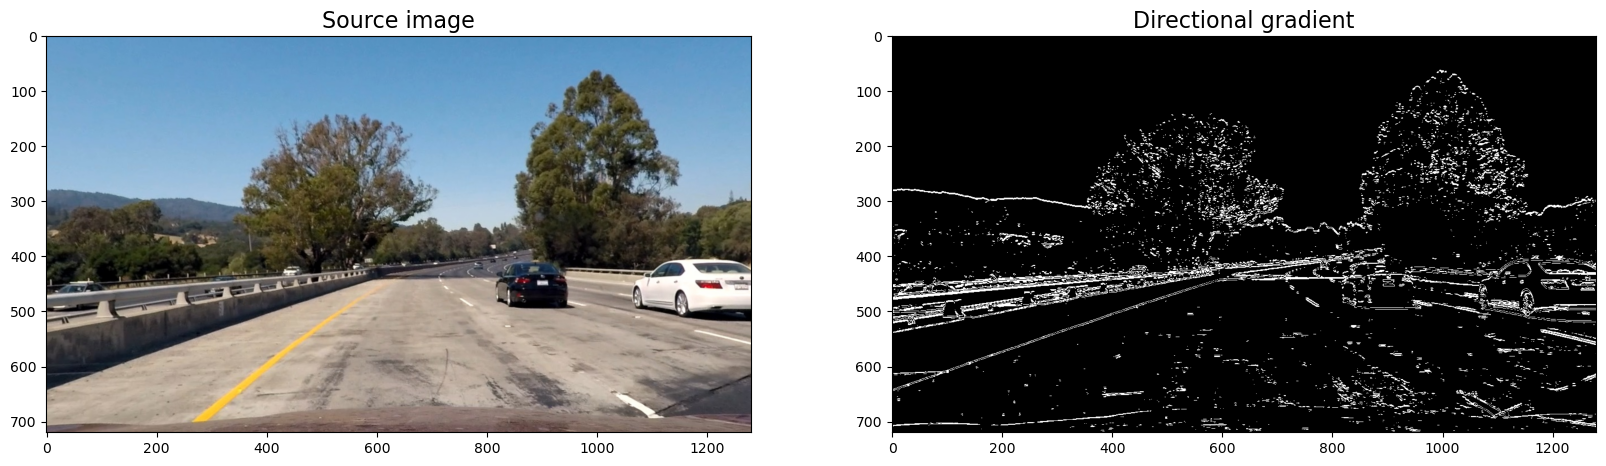

In [21]:
grad_y = abs_sobel_thresh(image, orient='y', thresh=(30, 100))
plt_images(image, 'Source image', grad_y, 'Directional gradient')

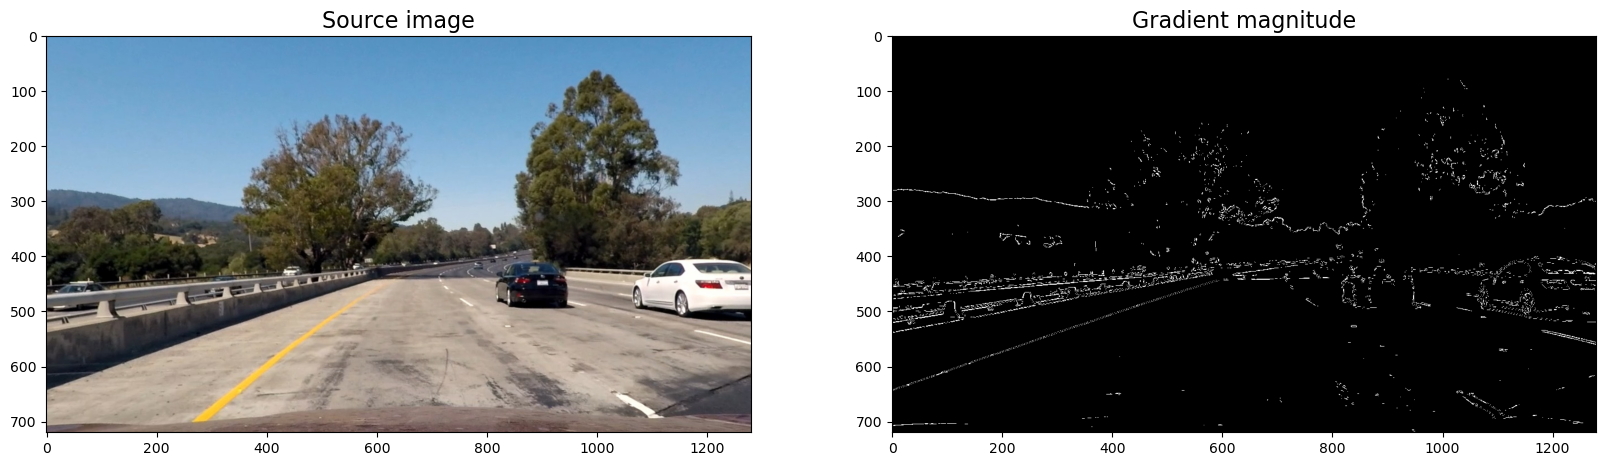

In [22]:
mag_binary = mag_thresh(image, sobel_kernel=3, thresh=(70, 100))
plt_images(image, 'Source image', mag_binary, 'Gradient magnitude')

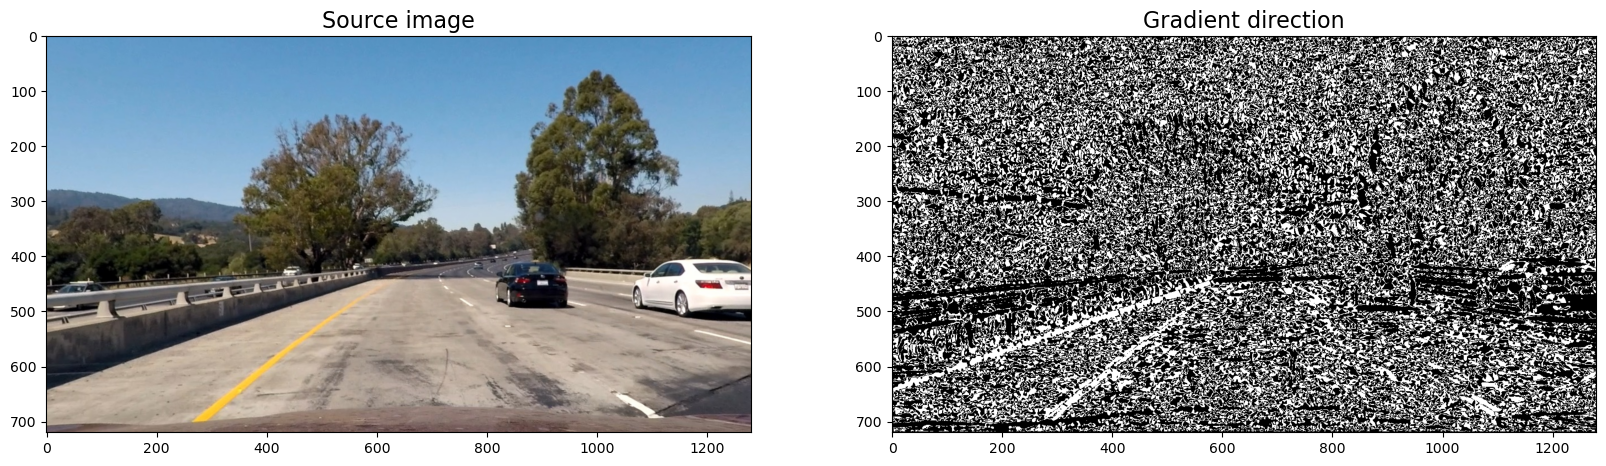

In [23]:
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
plt_images(image, 'Source image', dir_binary, 'Gradient direction')

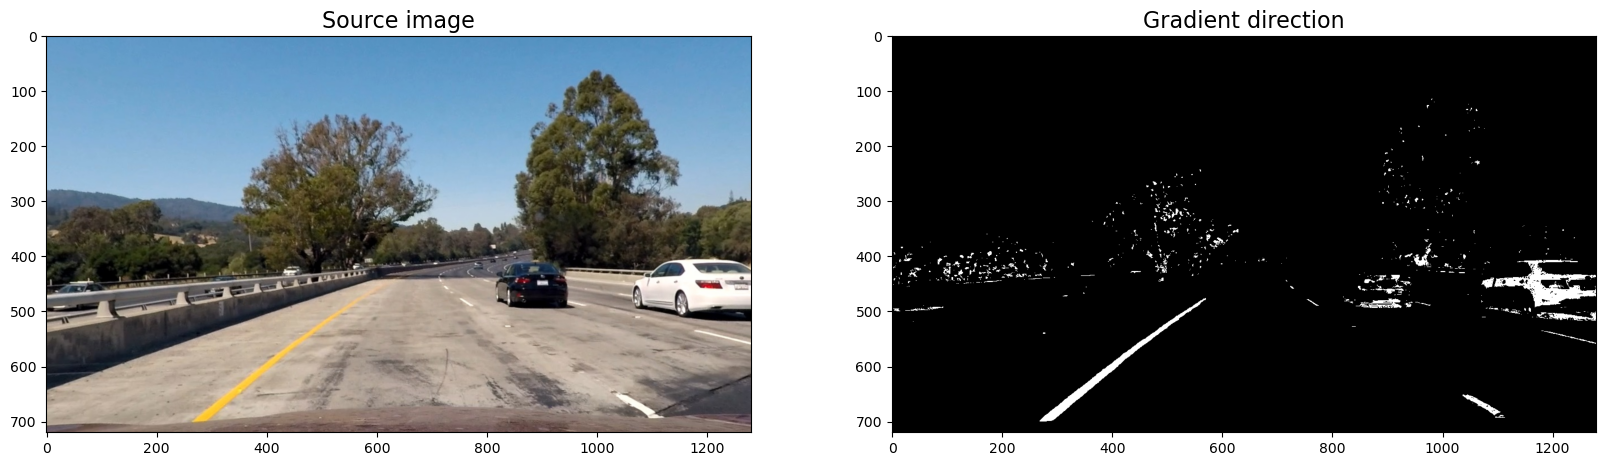

In [24]:
col_binary = col_thresh(image, thresh=(170, 255))
plt_images(image, 'Source image', col_binary, 'Gradient direction')

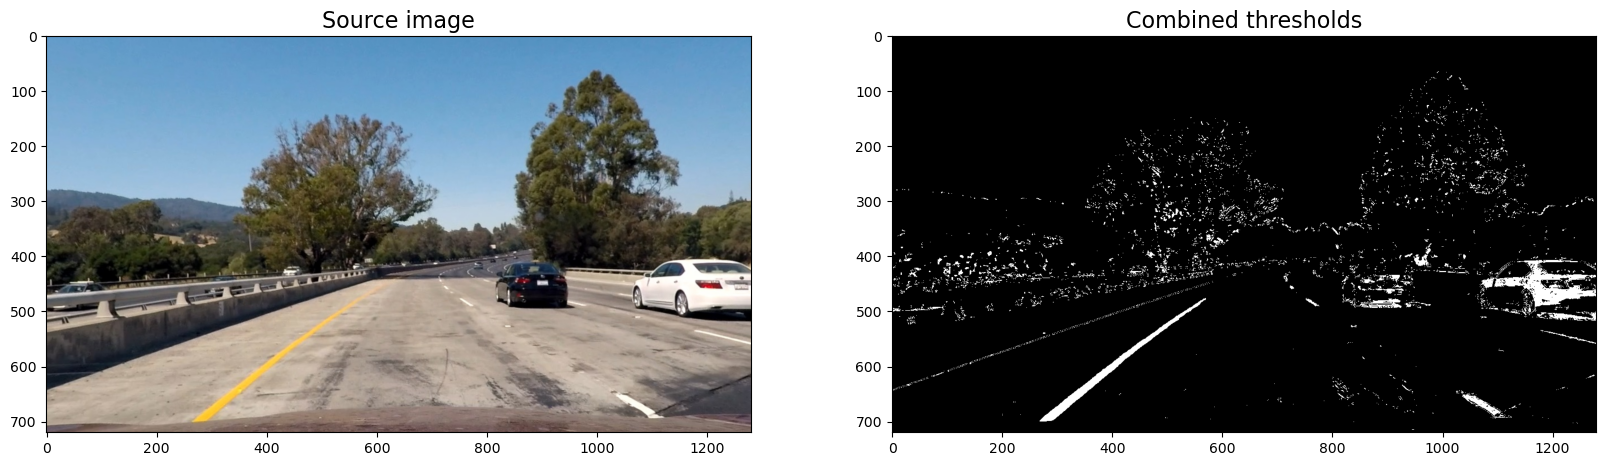

In [25]:
combined = combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, ksize=15)
plt_images(image, 'Source image', combined, 'Combined thresholds')

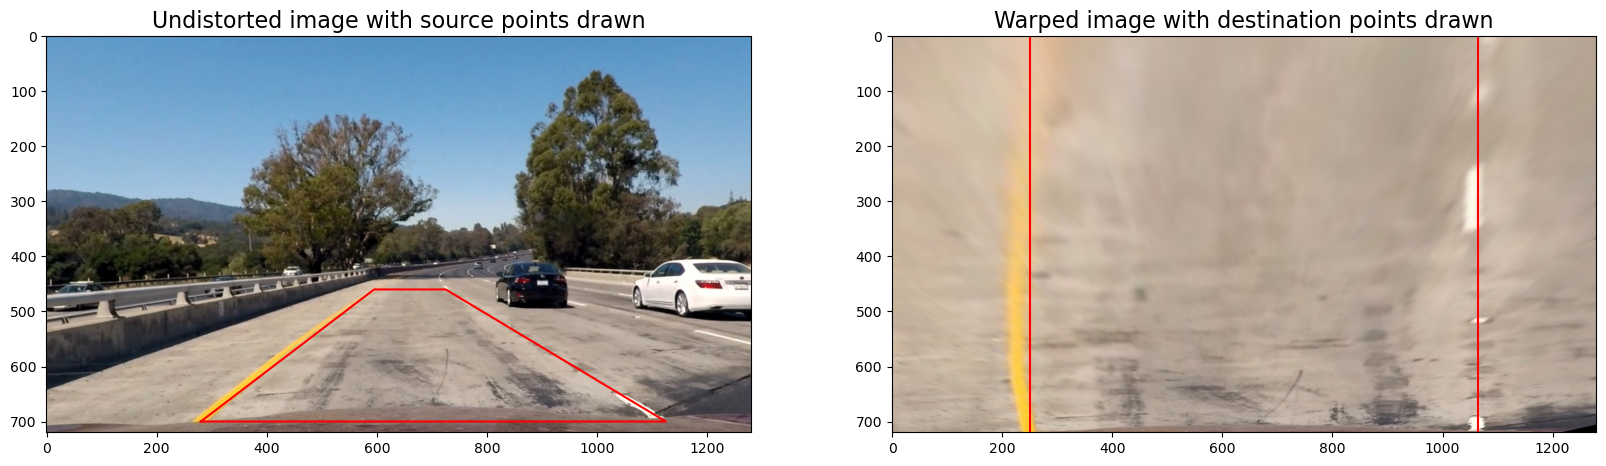

In [26]:
src_coordinates = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right 

warped_img, _ , Minv  = warp(image, src_coordinates, dst_coordinates)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src_coordinates).get_xy()[:, 0], Polygon(src_coordinates).get_xy()[:, 1], color='red')
ax1.imshow(image)

ax2.set_title('Warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dst_coordinates).get_xy()[:, 0], Polygon(dst_coordinates).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)

In [27]:
    if src_coordinates is None:
        src_coordinates = np.float32(
            [[280,  700],  
             [595,  460],  
             [725,  460],
             [1125, 700]]) 
        
    if dst_coordinates is None:
        dst_coordinates = np.float32(
            [[250,  720],  
             [250,    0],  
             [1065,   0], 
             [1065, 720]])  

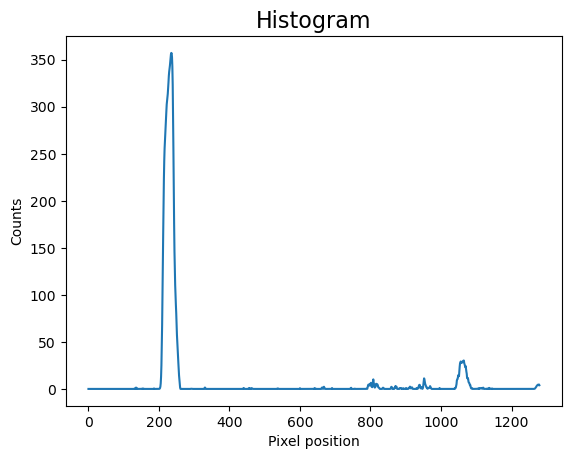

In [28]:

combined_warped = warp(combined)[0]
histogram = get_histogram(combined_warped)

# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)

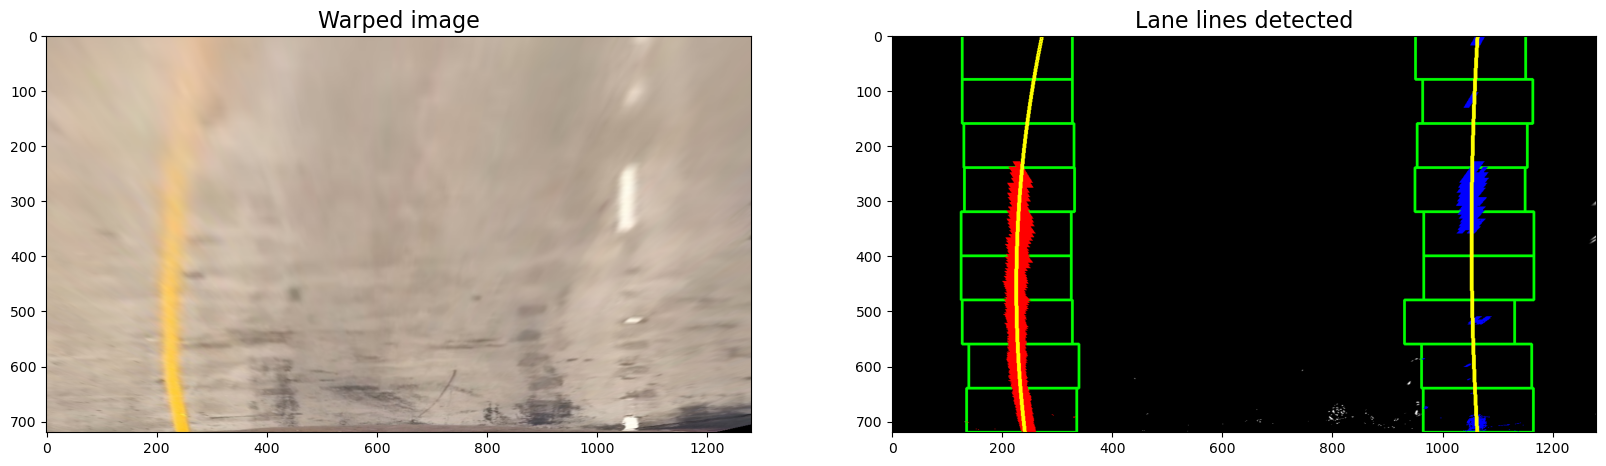

In [29]:
lines_fit, left_points, right_points, out_img = detect_lines(combined_warped, return_img=True)
plt_images(warped_img, 'Warped image', out_img, 'Lane lines detected')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


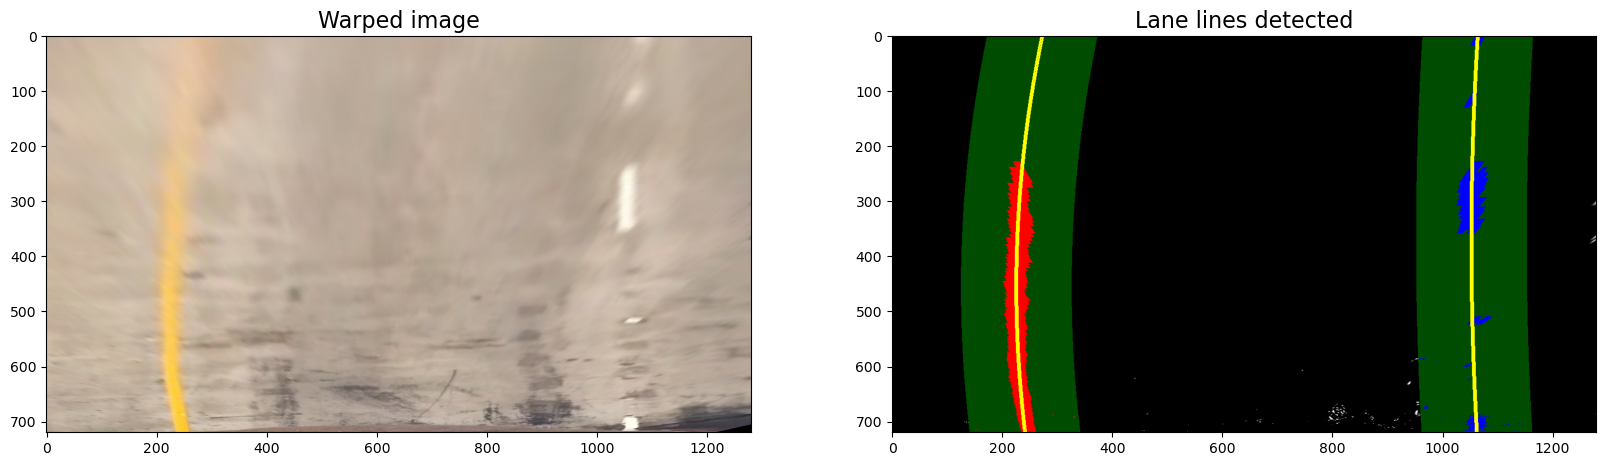

In [30]:
lines_fit, left_points, right_points, out_img = detect_similar_lines(combined_warped, lines_fit, return_img=True)
plt_images(warped_img, 'Warped image', out_img, 'Lane lines detected')

In [31]:
curvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')

Left line curvature: 571.3682271823737 m
Right line curvature: 1567.4887594822744 m


In [32]:
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)
print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.054144316161633746 m.


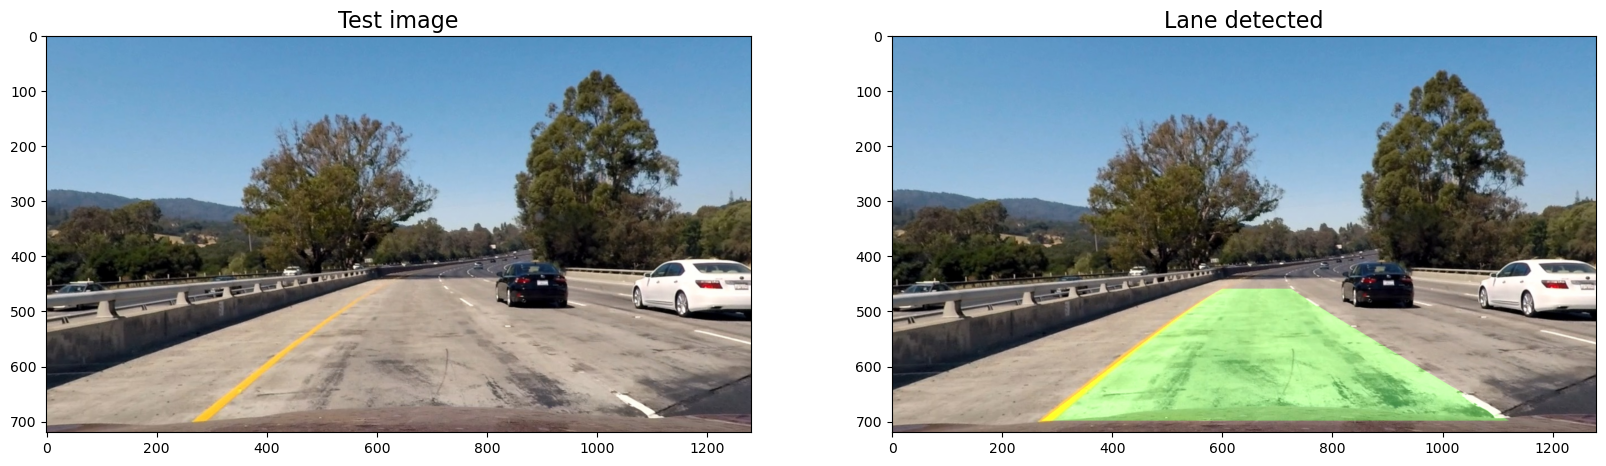

In [33]:
img_lane = draw_lane(image, combined_warped, left_points, right_points, Minv)
plt_images(image, 'Test image', img_lane, 'Lane detected')

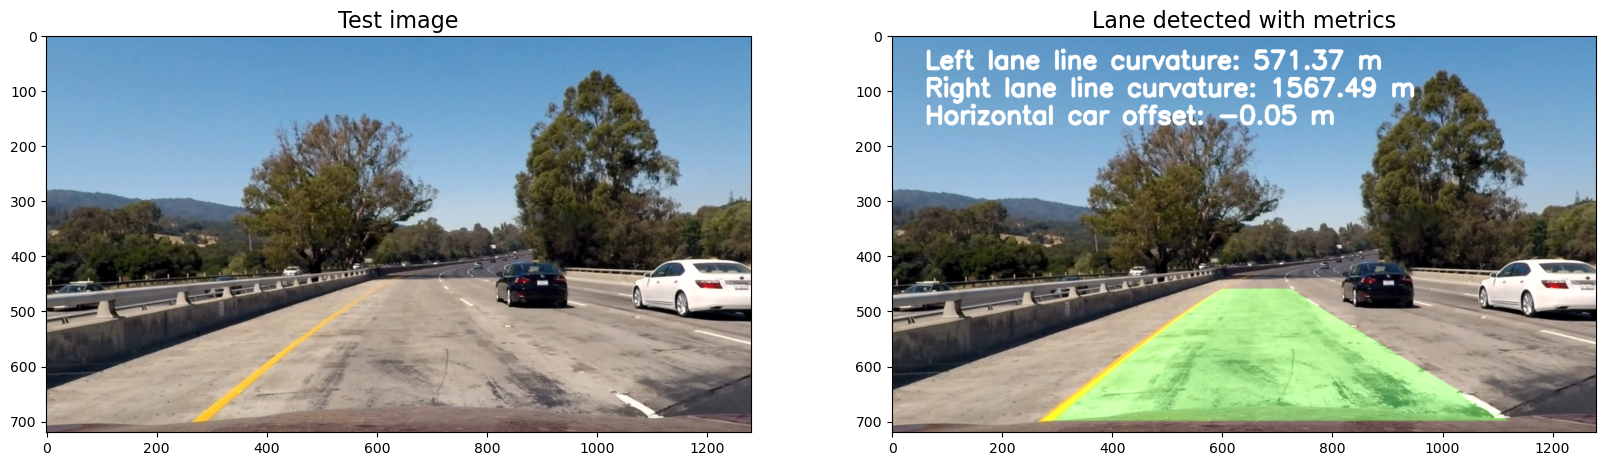

In [34]:
out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
plt_images(image, 'Test image', out_img, 'Lane detected with metrics')

In [35]:
class Pipeline:
    def __init__(self, images):

        images = glob.glob(images)

    
        self.mtx, self.dist = camera_calibration(images, 6, 9)
        self.lines_fit = None

    def __call__(self, img):
     
        img = cv2.undistort(img, mtx, dist, None, mtx)

        grad_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(30, 100))

    
        mag_binary = mag_thresh(img, sobel_kernel=15, thresh=(50, 100))

 
        dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

      
        col_binary = col_thresh(img, thresh=(170, 255))

       
        combined = combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, ksize=15)

     
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

        combined_warped, _, Minv = warp(combined, src_coordinates, dst_coordinates)
                
        self.lines_fit, left_points, right_points, out_img = detect_similar_lines(combined_warped, self.lines_fit, return_img=True)
        img_lane = draw_lane(img, combined_warped, left_points, right_points, Minv)
            
        out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
            
        return out_img

In [36]:
input_video = 'project_video.mp4'
output_video = 'project_video_solution.mp4'

clip1 = VideoFileClip(input_video)
process_image = Pipeline('camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

Moviepy - Building video project_video_solution.mp4.
Moviepy - Writing video project_video_solution.mp4



Moviepy - Done !
Moviepy - video ready project_video_solution.mp4
Wall time: 7min 45s


In [37]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))